In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
import torch
import torch.nn as nn
from torch.autograd import Variable
from torch.nn import functional as tf
from torch import Tensor
from torch.nn import Parameter
import torch.utils.data as Data
from torch.utils.data import RandomSampler
from torch.utils.data import DataLoader, TensorDataset
import torch.nn.functional as F
from sklearn.metrics import mean_squared_error
import pennylane as qml
import pytorch_lightning as pl
import math
import time



In [4]:
dfi = pd.read_csv('./Data/Electricity/RE_elecDemand.csv')
dfi

,Unnamed: 0,Time,Season,Day_of_the_week,DHI,DNI,GHI,Wind_speed,Humidity,Temperature,PV_production,Wind_production,Electric_demand
0,0,2019-01-01-T00:00,1,1,0.0,0.0,0.0,2.88,56.036,1.82,0,2810,22216
1,1,2019-01-01-T00:05,1,1,0.0,0.0,0.0,2.88,56.036,1.82,0,2862,22106
2,2,2019-01-01-T00:10,1,1,0.0,0.0,0.0,2.88,56.194,1.78,0,2916,22130
3,3,2019-01-01-T00:15,1,1,0.0,0.0,0.0,2.88,56.344,1.74,0,2920,22040
4,4,2019-01-01-T00:20,1,1,0.0,0.0,0.0,2.84,56.440,1.72,0,2902,21963
...,...,...,...,...,...,...,...,...,...,...,...,...,...
315643,315643,2021-12-31-T23:35,4,4,0.0,0.0,0.0,1.64,64.898,5.68,-33,3778,22939
315644,315644,2021-12-31-T23:40,4,4,0.0,0.0,0.0,1.64,64.970,5.66,-32,3755,22855
315645,315645,2021-12-31-T23:45,4,4,0.0,0.0,0.0,1.64,65.042,5.64,-31,3751,22812
315646,315646,2021-12-31-T23:50,4,4,0.0,0.0,0.0,1.64,65.234,5.60,-32,3793,22723


In [5]:
dfi['Time'] = pd.to_datetime(dfi['Time'])
dfi

,Unnamed: 0,Time,Season,Day_of_the_week,DHI,DNI,GHI,Wind_speed,Humidity,Temperature,PV_production,Wind_production,Electric_demand
0,0,2019-01-01 00:00:00,1,1,0.0,0.0,0.0,2.88,56.036,1.82,0,2810,22216
1,1,2019-01-01 00:05:00,1,1,0.0,0.0,0.0,2.88,56.036,1.82,0,2862,22106
2,2,2019-01-01 00:10:00,1,1,0.0,0.0,0.0,2.88,56.194,1.78,0,2916,22130
3,3,2019-01-01 00:15:00,1,1,0.0,0.0,0.0,2.88,56.344,1.74,0,2920,22040
4,4,2019-01-01 00:20:00,1,1,0.0,0.0,0.0,2.84,56.440,1.72,0,2902,21963
...,...,...,...,...,...,...,...,...,...,...,...,...,...
315643,315643,2021-12-31 23:35:00,4,4,0.0,0.0,0.0,1.64,64.898,5.68,-33,3778,22939
315644,315644,2021-12-31 23:40:00,4,4,0.0,0.0,0.0,1.64,64.970,5.66,-32,3755,22855
315645,315645,2021-12-31 23:45:00,4,4,0.0,0.0,0.0,1.64,65.042,5.64,-31,3751,22812
315646,315646,2021-12-31 23:50:00,4,4,0.0,0.0,0.0,1.64,65.234,5.60,-32,3793,22723


In [6]:
dfi = dfi.groupby([pd.Grouper(freq='H', key='Time')]).mean().reset_index()
dfi

,Time,Unnamed: 0,Season,Day_of_the_week,DHI,DNI,GHI,Wind_speed,Humidity,Temperature,PV_production,Wind_production,Electric_demand
0,2019-01-01 00:00:00,5.5,1.0,1.0,0.0,0.0,0.0,2.838333,55.809333,1.683333,0.000000,2812.083333,21851.416667
1,2019-01-01 01:00:00,17.5,1.0,1.0,0.0,0.0,0.0,2.770000,55.159000,1.405000,0.000000,2499.500000,21099.666667
2,2019-01-01 02:00:00,29.5,1.0,1.0,0.0,0.0,0.0,2.690000,54.532833,1.186667,0.000000,2387.083333,20495.416667
3,2019-01-01 03:00:00,41.5,1.0,1.0,0.0,0.0,0.0,2.655000,54.317833,0.985000,0.000000,2369.333333,20147.500000
4,2019-01-01 04:00:00,53.5,1.0,1.0,0.0,0.0,0.0,2.628333,54.296667,0.811667,0.000000,2323.083333,20144.416667
...,...,...,...,...,...,...,...,...,...,...,...,...,...
26299,2021-12-31 19:00:00,315593.5,4.0,4.0,0.0,0.0,0.0,1.718333,64.786667,7.090000,-31.083333,3440.416667,26447.333333
26300,2021-12-31 20:00:00,315605.5,4.0,4.0,0.0,0.0,0.0,1.658333,65.098167,6.751667,-32.166667,3448.916667,25743.083333
26301,2021-12-31 21:00:00,315617.5,4.0,4.0,0.0,0.0,0.0,1.661667,65.315667,6.405000,-31.666667,3673.500000,25009.250000
26302,2021-12-31 22:00:00,315629.5,4.0,4.0,0.0,0.0,0.0,1.675000,65.576167,6.045000,-31.083333,3826.000000,24060.250000


<Axes: >

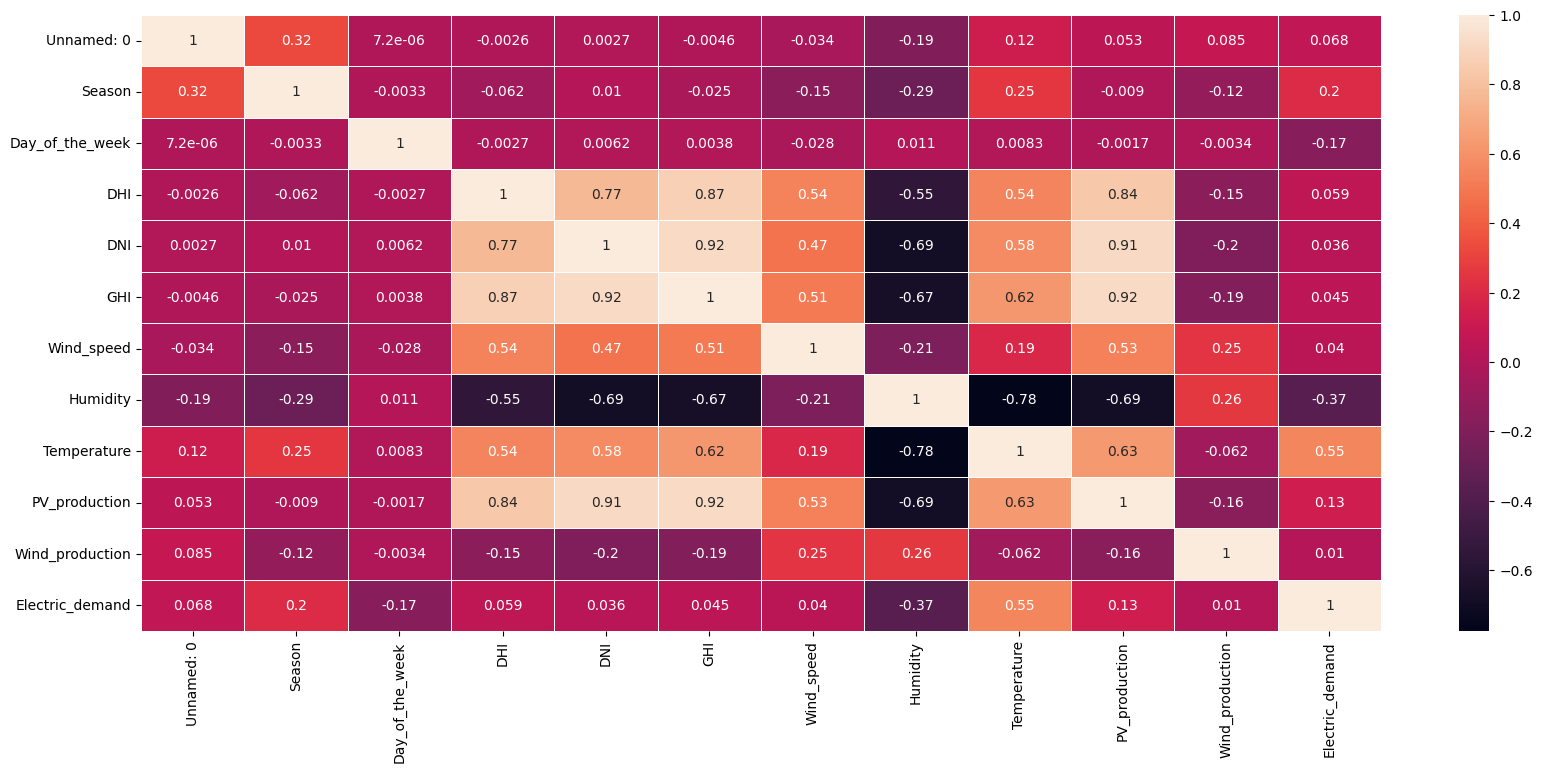

In [7]:
import seaborn as sns
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(20,8))
corr = dfi.select_dtypes('number').corr()
sns.heatmap(data=corr, annot=True, linewidths=.5,ax=ax)

In [8]:
df = dfi.loc[dfi['Time'] > '2021-07-01']
df.reset_index(inplace=True)
df.drop(['Time','index','Unnamed: 0','Season','Day_of_the_week','DHI','DNI','GHI','Wind_production'],axis=1,inplace=True)
df

/tmp/ipykernel_49421/1223416517.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.drop(['Time','index','Unnamed: 0','Season','Day_of_the_week','DHI','DNI','GHI','Wind_production'],axis=1,inplace=True)


,Wind_speed,Humidity,Temperature,PV_production,Electric_demand
0,2.173333,61.006167,20.168333,-26.833333,25633.916667
1,2.163333,62.209167,19.781667,-27.333333,24665.083333
2,2.113333,63.125500,19.521667,-26.583333,24081.250000
3,2.105000,62.260500,19.936667,-28.666667,24046.666667
4,2.246667,57.512833,21.611667,-19.333333,24650.666667
...,...,...,...,...,...
4410,1.718333,64.786667,7.090000,-31.083333,26447.333333
4411,1.658333,65.098167,6.751667,-32.166667,25743.083333
4412,1.661667,65.315667,6.405000,-31.666667,25009.250000
4413,1.675000,65.576167,6.045000,-31.083333,24060.250000


In [9]:
df.ffill()

,Wind_speed,Humidity,Temperature,PV_production,Electric_demand
0,2.173333,61.006167,20.168333,-26.833333,25633.916667
1,2.163333,62.209167,19.781667,-27.333333,24665.083333
2,2.113333,63.125500,19.521667,-26.583333,24081.250000
3,2.105000,62.260500,19.936667,-28.666667,24046.666667
4,2.246667,57.512833,21.611667,-19.333333,24650.666667
...,...,...,...,...,...
4410,1.718333,64.786667,7.090000,-31.083333,26447.333333
4411,1.658333,65.098167,6.751667,-32.166667,25743.083333
4412,1.661667,65.315667,6.405000,-31.666667,25009.250000
4413,1.675000,65.576167,6.045000,-31.083333,24060.250000


In [10]:
# Descriptive statistics
df.describe().T

,count,mean,std,min,25%,50%,75%,max
Wind_speed,4415.0,2.469447,0.979284,0.691667,1.718333,2.293333,3.069167,8.465000
Humidity,4415.0,48.914517,15.732358,17.199833,36.460250,49.000333,60.112750,85.087667
Temperature,4415.0,19.802525,7.807649,2.263333,13.685833,20.010000,25.037500,37.316667
PV_production,4415.0,3746.645998,4647.386451,-81.333333,-39.916667,118.333333,8648.791667,12750.916667
Electric_demand,4415.0,26414.435598,5222.736921,17294.000000,22616.583333,25237.916667,28765.583333,43762.416667


In [11]:
df['nxt_target'] = df['Electric_demand'].shift(-1)
df['nxt_target'][len(df)-1] = df['nxt_target'][len(df)-2]
df

/tmp/ipykernel_49421/2374012871.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['nxt_target'] = df['Electric_demand'].shift(-1)
/tmp/ipykernel_49421/2374012871.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['nxt_target'][len(df)-1] = df['nxt_target'][len(df)-2]


,Wind_speed,Humidity,Temperature,PV_production,Electric_demand,nxt_target
0,2.173333,61.006167,20.168333,-26.833333,25633.916667,24665.083333
1,2.163333,62.209167,19.781667,-27.333333,24665.083333,24081.250000
2,2.113333,63.125500,19.521667,-26.583333,24081.250000,24046.666667
3,2.105000,62.260500,19.936667,-28.666667,24046.666667,24650.666667
4,2.246667,57.512833,21.611667,-19.333333,24650.666667,25514.916667
...,...,...,...,...,...,...
4410,1.718333,64.786667,7.090000,-31.083333,26447.333333,25743.083333
4411,1.658333,65.098167,6.751667,-32.166667,25743.083333,25009.250000
4412,1.661667,65.315667,6.405000,-31.666667,25009.250000,24060.250000
4413,1.675000,65.576167,6.045000,-31.083333,24060.250000,23071.916667


In [12]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4415 entries, 0 to 4414
Data columns (total 6 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Wind_speed       4415 non-null   float64
 1   Humidity         4415 non-null   float64
 2   Temperature      4415 non-null   float64
 3   PV_production    4415 non-null   float64
 4   Electric_demand  4415 non-null   float64
 5   nxt_target       4415 non-null   float64
dtypes: float64(6)
memory usage: 207.1 KB


In [13]:
size = int(len(df) * 0.8)

train = df.iloc[:size].copy()
test = df.iloc[size:].copy()
train

,Wind_speed,Humidity,Temperature,PV_production,Electric_demand,nxt_target
0,2.173333,61.006167,20.168333,-26.833333,25633.916667,24665.083333
1,2.163333,62.209167,19.781667,-27.333333,24665.083333,24081.250000
2,2.113333,63.125500,19.521667,-26.583333,24081.250000,24046.666667
3,2.105000,62.260500,19.936667,-28.666667,24046.666667,24650.666667
4,2.246667,57.512833,21.611667,-19.333333,24650.666667,25514.916667
...,...,...,...,...,...,...
3527,2.210000,47.981500,7.928333,-40.416667,21098.416667,20329.333333
3528,2.118333,47.240167,7.671667,-40.916667,20329.333333,19679.500000
3529,2.086667,46.302000,7.495000,-41.000000,19679.500000,19372.250000
3530,2.125000,45.312167,7.408333,-42.166667,19372.250000,19405.583333


In [14]:
train.iloc[:,-1:]

,nxt_target
0,24665.083333
1,24081.250000
2,24046.666667
3,24650.666667
4,25514.916667
...,...
3527,20329.333333
3528,19679.500000
3529,19372.250000
3530,19405.583333


In [15]:
train.iloc[:,:5]

,Wind_speed,Humidity,Temperature,PV_production,Electric_demand
0,2.173333,61.006167,20.168333,-26.833333,25633.916667
1,2.163333,62.209167,19.781667,-27.333333,24665.083333
2,2.113333,63.125500,19.521667,-26.583333,24081.250000
3,2.105000,62.260500,19.936667,-28.666667,24046.666667
4,2.246667,57.512833,21.611667,-19.333333,24650.666667
...,...,...,...,...,...
3527,2.210000,47.981500,7.928333,-40.416667,21098.416667
3528,2.118333,47.240167,7.671667,-40.916667,20329.333333
3529,2.086667,46.302000,7.495000,-41.000000,19679.500000
3530,2.125000,45.312167,7.408333,-42.166667,19372.250000


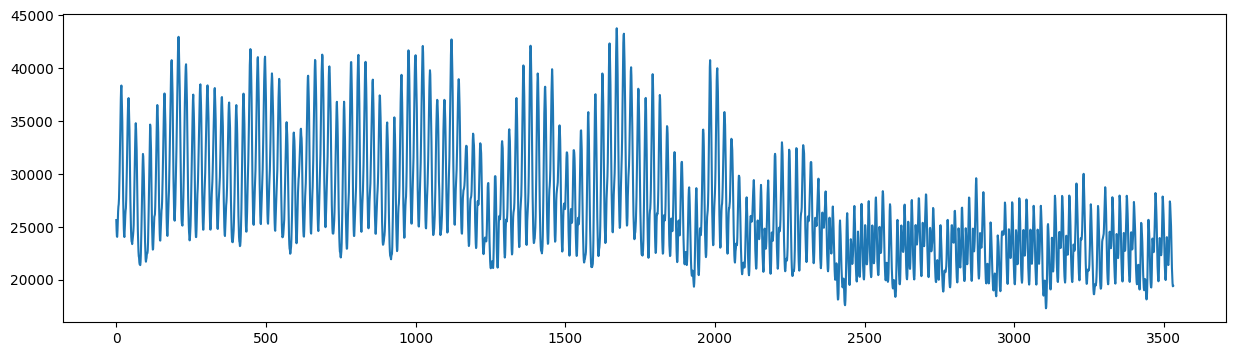

In [16]:
%matplotlib inline
plt.figure(figsize=(15, 4))
plt.plot(range(len(train)), train["Electric_demand"])
plt.show()

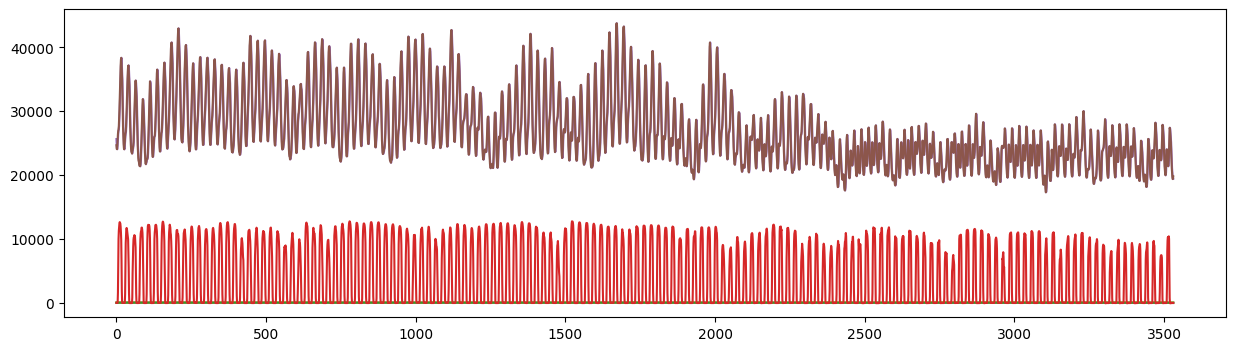

In [17]:
plt.figure(figsize=(15, 4))
plt.plot(train)
plt.show()

In [18]:
def data_process(data, window_size, predict_size):
    scaler1 = StandardScaler()
    scaler2 = StandardScaler()
    d_y = scaler1.fit_transform(data.iloc[:,-1:])
    data = scaler2.fit_transform(data.iloc[:,:5])

    data_in = []
    data_out = []
    # range(window_size,len(data)-predict_size+1) range(data.shape[0] - window_size - predict_size + 1)
    for i in range(window_size,len(data)-predict_size+1):
        data_in.append(data[i-window_size:i,0:data.shape[0]])
        data_out.append(d_y[i + predict_size - 1:i + predict_size,0])

    data_in = np.array(data_in)
    data_out = np.array(data_out)

    data_process = {'datain': data_in, 'dataout': data_out}

    return data_process, scaler1 , scaler2

In [19]:
from numpy.random import default_rng
from qiskit_algorithms.utils import algorithm_globals
qubits = 5
seed = 42
np.random.seed(seed)
torch.manual_seed(42)
rng = default_rng(seed)
algorithm_globals.random_seed = seed
features_size = 5
#window_size = features_size * 3
window_size = 10
predict_size = 1

In [20]:
train_processed, train_target_scalar, train_scaler = data_process(train, window_size, predict_size)
X_train, y_train = train_processed['datain'], train_processed['dataout']

test_processed, test_target_scalar, test_scaler = data_process(test, window_size, predict_size)
X_test, y_test = test_processed['datain'], test_processed['dataout']

In [21]:
X_train = torch.from_numpy(X_train.astype(np.float32))
X_test = torch.from_numpy(X_test.astype(np.float32))

y_train = torch.from_numpy(y_train.astype(np.float32))
y_test = torch.from_numpy(y_test.astype(np.float32))

In [22]:
print(X_train.shape)
batch_size, seq_length, features_size =X_train.size()
print(batch_size)
X_train[0][0]

torch.Size([3522, 10, 5])
3522


tensor([-0.3195,  1.0498, -0.2991, -0.8557, -0.2545])

In [23]:
device = "cpu"

In [24]:
def init_hidden(x: torch.Tensor, hidden_size: int, num_dir: int = 1, xavier: bool = True):
    
    if xavier:
        return nn.init.xavier_normal_(torch.zeros(num_dir, x.size(0), hidden_size)).to(device)
    return Variable(torch.zeros(num_dir, x.size(0), hidden_size)).to(device)

In [25]:
class AttnEncoder(nn.Module):
    def __init__(self, input_size: int, hidden_size: int, batch_first: bool = True,seq_len:int=10):
        
        super(AttnEncoder, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.seq_len = seq_len
        
        self.lstm = nn.LSTM(
            input_size=self.input_size,
            hidden_size=self.hidden_size,
            num_layers=1
        )
        self.attn = nn.Linear(
            in_features=2 * self.hidden_size + self.seq_len,
            out_features=1
        )
        self.softmax = nn.Softmax(dim=1)

    
    def forward(self, input_data: torch.Tensor):
        
        h_t, c_t = (init_hidden(input_data, self.hidden_size),
                    init_hidden(input_data, self.hidden_size))

        attentions, input_encoded = (Variable(torch.zeros(input_data.size(0), self.seq_len, self.input_size)),
                                     Variable(torch.zeros(input_data.size(0), self.seq_len, self.hidden_size)))

        
        for t in range(self.seq_len):
            x = torch.cat((h_t.repeat(self.input_size, 1, 1).permute(1, 0, 2),
                           c_t.repeat(self.input_size, 1, 1).permute(1, 0, 2),
                           input_data.permute(0, 2, 1).to(device)), dim=2).to(
                device)  # bs * input_size * (2 * hidden_dim + seq_len)

            e_t = self.attn(x.view(-1, self.hidden_size * 2 + self.seq_len))  # (bs * input_size) * 1
            a_t = self.softmax(e_t.view(-1, self.input_size)).to(device)  # (bs, input_size)

            weighted_input = torch.mul(a_t, input_data[:, t, :].to(device))  # (bs * input_size)
            self.lstm.flatten_parameters()
            _, (h_t, c_t) = self.lstm(weighted_input.unsqueeze(0), (h_t, c_t))

            input_encoded[:, t, :] = h_t
            attentions[:, t, :] = a_t

        return attentions, input_encoded

In [26]:
class AttnDecoder(nn.Module):
    def __init__(self,  hidden_size: int, batch_first: bool = True,seq_len:int=10):
        
        super(AttnDecoder, self).__init__()
        self.seq_len = seq_len
        self.encoder_hidden_size = hidden_size
        self.decoder_hidden_size = hidden_size
        self.out_feats = 1

        self.attn = nn.Sequential(
            nn.Linear(2 * self.decoder_hidden_size + self.encoder_hidden_size, self.encoder_hidden_size),
            nn.Tanh(),
            nn.Linear(self.encoder_hidden_size, 1)
        )
        self.lstm = nn.LSTM(input_size=self.out_feats, hidden_size=self.decoder_hidden_size)
        self.fc = nn.Linear(self.encoder_hidden_size + self.out_feats, self.out_feats)
        self.fc_out = nn.Linear(self.decoder_hidden_size + self.encoder_hidden_size, self.out_feats)
        self.fc.weight.data.normal_()

    def forward(self, input_encoded: torch.Tensor, y_history: torch.Tensor):
        
        h_t, c_t = (
            init_hidden(input_encoded, self.decoder_hidden_size), init_hidden(input_encoded, self.decoder_hidden_size))
        context = Variable(torch.zeros(input_encoded.size(0), self.encoder_hidden_size))

        for t in range(self.seq_len):
            x = torch.cat((h_t.repeat(self.seq_len, 1, 1).permute(1, 0, 2),
                           c_t.repeat(self.seq_len, 1, 1).permute(1, 0, 2),
                           input_encoded.to(device)), dim=2)

            x = tf.softmax(
                self.attn(
                    x.view(-1, 2 * self.decoder_hidden_size + self.encoder_hidden_size)
                ).view(-1, self.seq_len),
                dim=1)

            context = torch.bmm(x.unsqueeze(1), input_encoded.to(device))[:, 0, :]  # (batch_size, encoder_hidden_size)
            #print('context yhis',context.to(device).size(), y_history.to(device).size())
            y_tilde = self.fc(torch.cat((context.to(device), y_history.to(device)),
                                        dim=1))  # (batch_size, out_size)

            self.lstm.flatten_parameters()
            _, (h_t, c_t) = self.lstm(y_tilde.unsqueeze(0), (h_t, c_t))

        return self.fc_out(torch.cat((h_t[0], context.to(device)), dim=1))  # predicting value at t=self.seq_length+1



In [27]:
class AutoEncForecast(nn.Module):
    def __init__(self,input_size: int, hidden_size: int, batch_first: bool = True, n_qubits:int=4, n_qlayers:int=1,seq_len:int=10):
        super(AutoEncForecast, self).__init__()
        self.encoder = AttnEncoder(input_size, hidden_size, batch_first,seq_len).to(device)
        self.decoder = AttnDecoder(hidden_size, batch_first, seq_len).to(device)

    def forward(self, encoder_input: torch.Tensor, y_hist: torch.Tensor, return_attention: bool = False):
       
        attentions, encoder_output = self.encoder(encoder_input)
        outputs = self.decoder(encoder_output, y_hist.float())
        outputs = torch.transpose(outputs, 0, 1)
        if return_attention:
            return outputs, attentions
        return outputs

In [28]:
batch_size = 5
learning_rate = 0.004
num_epochs = 5
trainDataloader = DataLoader(TensorDataset(X_train, y_train), batch_size = batch_size, shuffle = False)
testDataloader = DataLoader(TensorDataset(X_test,y_test), batch_size = batch_size, shuffle = False)
device = "cpu"
modelQ = AutoEncForecast(input_size=5, hidden_size= 12)
criterion = nn.MSELoss()
optimizerQ = torch.optim.Adam(modelQ.parameters(), lr = learning_rate, betas = (0.0, 0.9))

In [29]:
histQ = np.zeros(num_epochs)
histQacc = np.zeros(num_epochs)
count = 0


for epoch in range(num_epochs):
    loss_Q = []
    rmse_q = []
    correct = 0
    batches = 0
    for (x, y) in trainDataloader:
        modelQ.zero_grad()
        x = x.to(device)
        y = y.to(device)
        
        output = modelQ(x,y)
        
        label = torch.transpose(y, 0, 1)    
        #print(output)
        #print(torch.transpose(y, 0, 1))
        
        lossQ = criterion(output, label)
        lossQ.backward()
        optimizerQ.step()
        
        #correct += (output == label).float().sum()
        #batches +=1
        
        loss_Q.append(lossQ.item())
    histQ[epoch] = np.sum(loss_Q)
    #print(correct)
    #histQacc[epoch] = correct/batches
    print(f'[{epoch+1}/{num_epochs}]  LossQ:{np.sum(loss_Q)} ')

[1/5]  LossQ:43.41068086020823 
[2/5]  LossQ:4.213900427679619 
[3/5]  LossQ:2.0453522703101044 
[4/5]  LossQ:1.2901339052687035 
[5/5]  LossQ:0.8128695524858358 


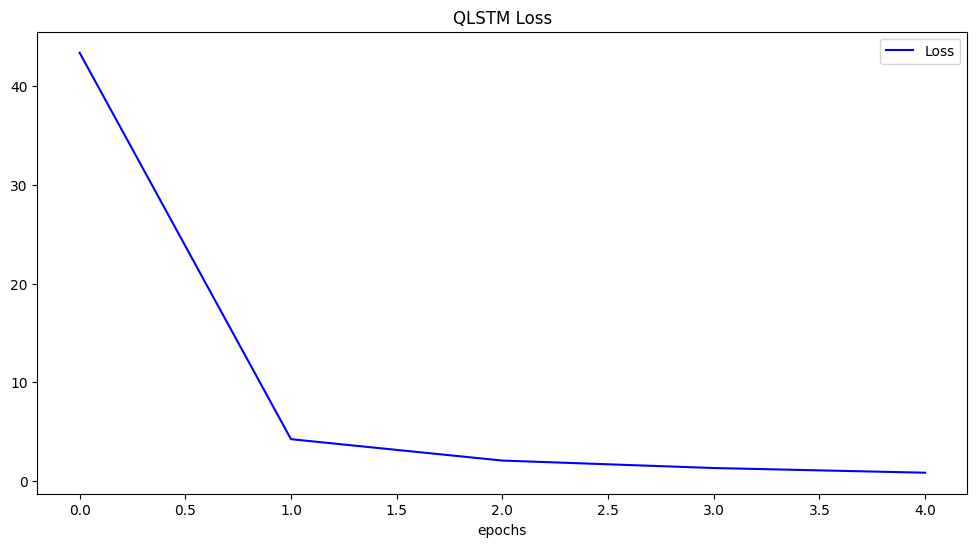

In [30]:
np.savetxt('./SavedModels/Electricity/RE_elecDemand/loss/clstm_attn.txt',histQ)
plt.figure(figsize = (12, 6))
plt.plot(histQ, color = 'blue', label = 'Loss')
plt.title('QLSTM Loss')
plt.xlabel('epochs')
plt.legend(loc = 'upper right')

In [31]:
print(len(X_test))
print(len(X_train))
print(len(y_train))
#print(X_train[0].unsqueeze(0))
#print(y_train[0].unsqueeze(0))

873
3522
3522


In [32]:
def predict(X,y, model):
    """Just like `test_loop` function but keep track of the outputs instead of the loss
    function.
    """
    output = torch.tensor([])
    model.eval()
    with torch.no_grad():
        for i in range(len(X)):
            y_star = model(X[i].unsqueeze(0),y[i].unsqueeze(0))
            '''if list(y_star.size()) == [1,1]:
                y_star = y_star.tolist()
                y_star[0]+= [y_star[0][0]]
                y_star[0]+= [y_star[0][0]]
                y_star[0]+= [y_star[0][0]]
                y_star = torch.tensor(y_star)'''
            output = torch.cat((output, y_star), 0)


    return output

In [33]:
pred_y_test = predict(X_test,y_test, modelQ)
print(len(pred_y_test))
print(pred_y_test)

873
tensor([[-4.0086e-01],
        [-5.5290e-02],
        [-2.6524e-01],
        [-3.4964e-01],
        [-4.5335e-01],
        [-6.0502e-01],
        [-8.3374e-01],
        [-1.0641e+00],
        [-1.3256e+00],
        [-1.4928e+00],
        [-1.5541e+00],
        [-1.6045e+00],
        [-1.5845e+00],
        [-1.3894e+00],
        [-1.0902e+00],
        [-1.0206e+00],
        [-1.1873e+00],
        [-1.4489e+00],
        [-1.6480e+00],
        [-1.7572e+00],
        [-1.7029e+00],
        [-1.5412e+00],
        [-1.1653e+00],
        [-6.4908e-01],
        [-7.7218e-02],
        [ 4.8775e-01],
        [ 4.4009e-01],
        [ 2.6668e-01],
        [ 8.9978e-02],
        [-1.3658e-01],
        [-4.6201e-01],
        [-8.3874e-01],
        [-1.1653e+00],
        [-1.3910e+00],
        [-1.5120e+00],
        [-1.5551e+00],
        [-1.5499e+00],
        [-1.4127e+00],
        [-1.1920e+00],
        [-1.1526e+00],
        [-1.3364e+00],
        [-1.5656e+00],
        [-1.7334e+00],
       

In [34]:
pred_y_train = predict(X_train,y_train, modelQ)
print(len(pred_y_train))
print(pred_y_train)

3522
tensor([[ 0.5693],
        [ 0.8609],
        [ 1.2000],
        ...,
        [-1.3572],
        [-1.3510],
        [-1.2732]])


In [35]:
pred_y_train = pred_y_train.reshape(-1, 1)
pred_y_test = pred_y_test.reshape(-1, 1)


In [36]:
print(len(pred_y_train))
print(len(y_train))

3522
3522


In [37]:
pred_y_test

tensor([[-4.0086e-01],
        [-5.5290e-02],
        [-2.6524e-01],
        [-3.4964e-01],
        [-4.5335e-01],
        [-6.0502e-01],
        [-8.3374e-01],
        [-1.0641e+00],
        [-1.3256e+00],
        [-1.4928e+00],
        [-1.5541e+00],
        [-1.6045e+00],
        [-1.5845e+00],
        [-1.3894e+00],
        [-1.0902e+00],
        [-1.0206e+00],
        [-1.1873e+00],
        [-1.4489e+00],
        [-1.6480e+00],
        [-1.7572e+00],
        [-1.7029e+00],
        [-1.5412e+00],
        [-1.1653e+00],
        [-6.4908e-01],
        [-7.7218e-02],
        [ 4.8775e-01],
        [ 4.4009e-01],
        [ 2.6668e-01],
        [ 8.9978e-02],
        [-1.3658e-01],
        [-4.6201e-01],
        [-8.3874e-01],
        [-1.1653e+00],
        [-1.3910e+00],
        [-1.5120e+00],
        [-1.5551e+00],
        [-1.5499e+00],
        [-1.4127e+00],
        [-1.1920e+00],
        [-1.1526e+00],
        [-1.3364e+00],
        [-1.5656e+00],
        [-1.7334e+00],
        [-1

In [38]:
y_train_true = train_target_scalar.inverse_transform(y_train)
y_train_pred = train_target_scalar.inverse_transform(pred_y_train.cpu().detach().numpy())
y_test_true = test_target_scalar.inverse_transform(y_test)
y_test_pred = test_target_scalar.inverse_transform(pred_y_test.cpu().detach().numpy())

In [39]:
np.savetxt('./SavedModels/Electricity/RE_elecDemand/train/clstm_attn.txt',y_train_pred)
np.savetxt('./SavedModels/Electricity/RE_elecDemand/test/clstm_attn.txt',y_test_pred)

Training dataset RMSE:229.36116486658239


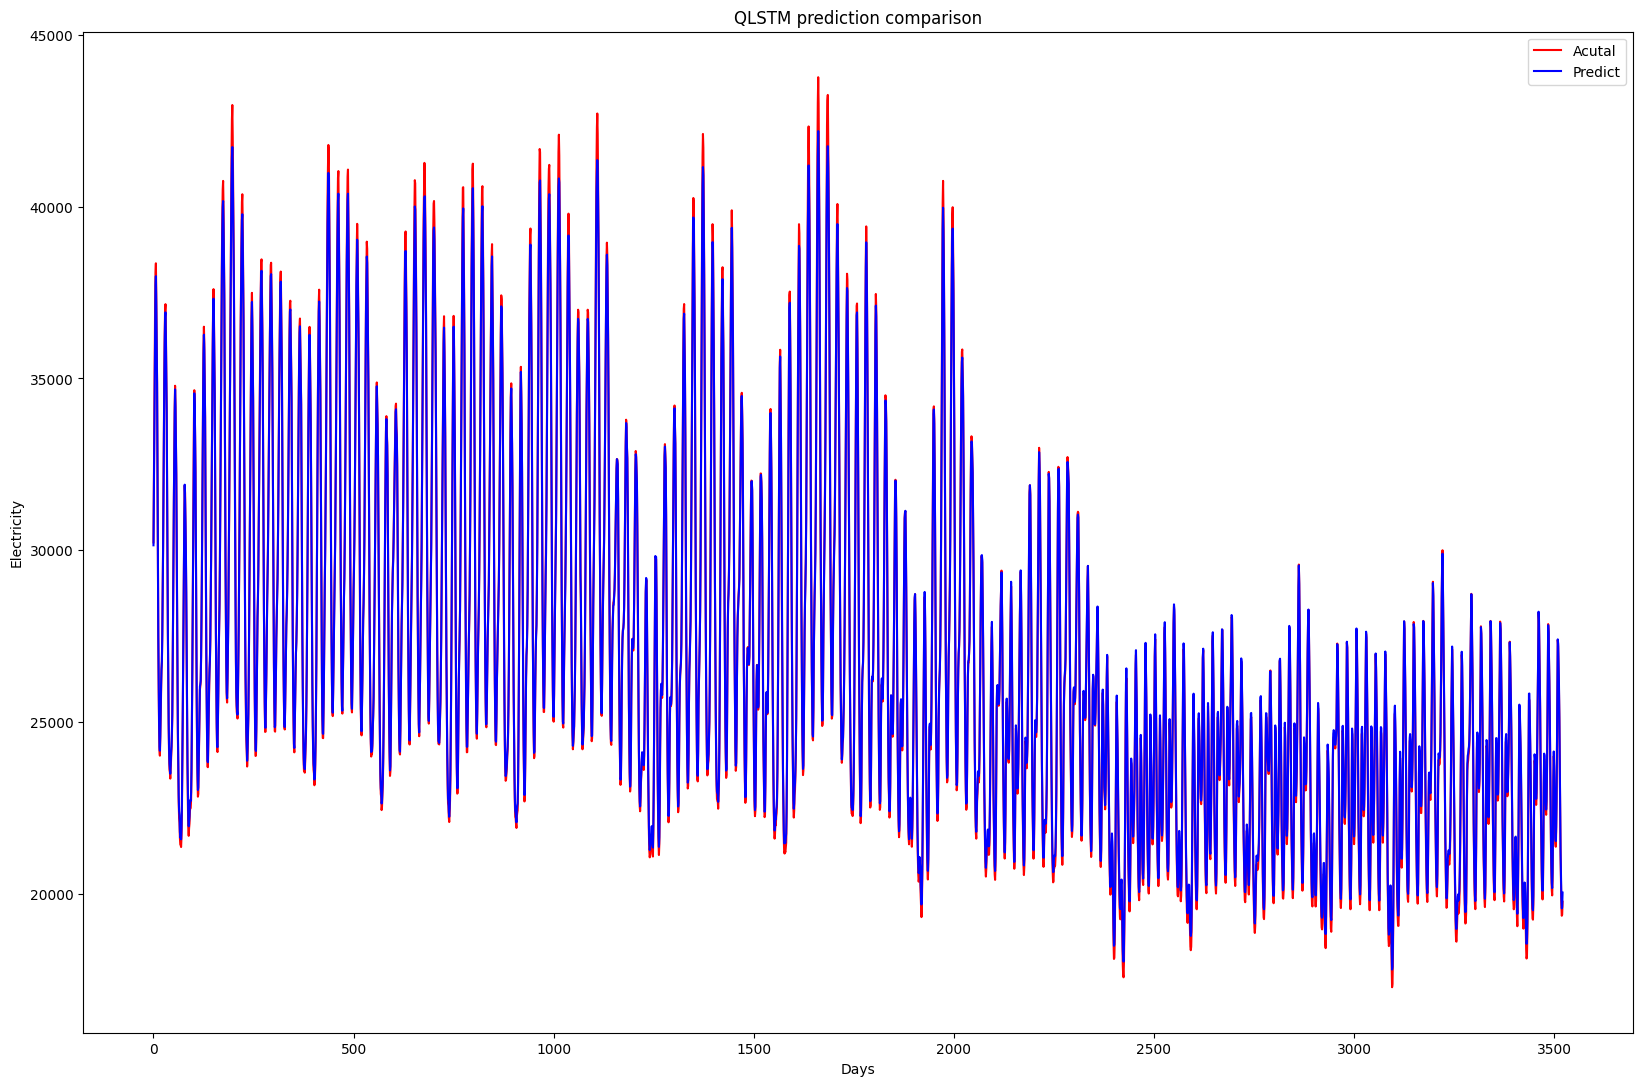

In [40]:
plt.figure(figsize=(20, 13))
plt.plot(y_train_true, color = 'red', label = 'Acutal')
plt.plot(y_train_pred, color = 'blue', label = 'Predict')
plt.title('QLSTM prediction comparison')
plt.ylabel('Electricity')
plt.xlabel('Days')
plt.legend(loc = 'upper right')

MSE = mean_squared_error(y_train_true, y_train_pred)
RMSE = math.sqrt(MSE)
print(f'Training dataset RMSE:{RMSE}')

Training dataset RMSE:206.40166813494048


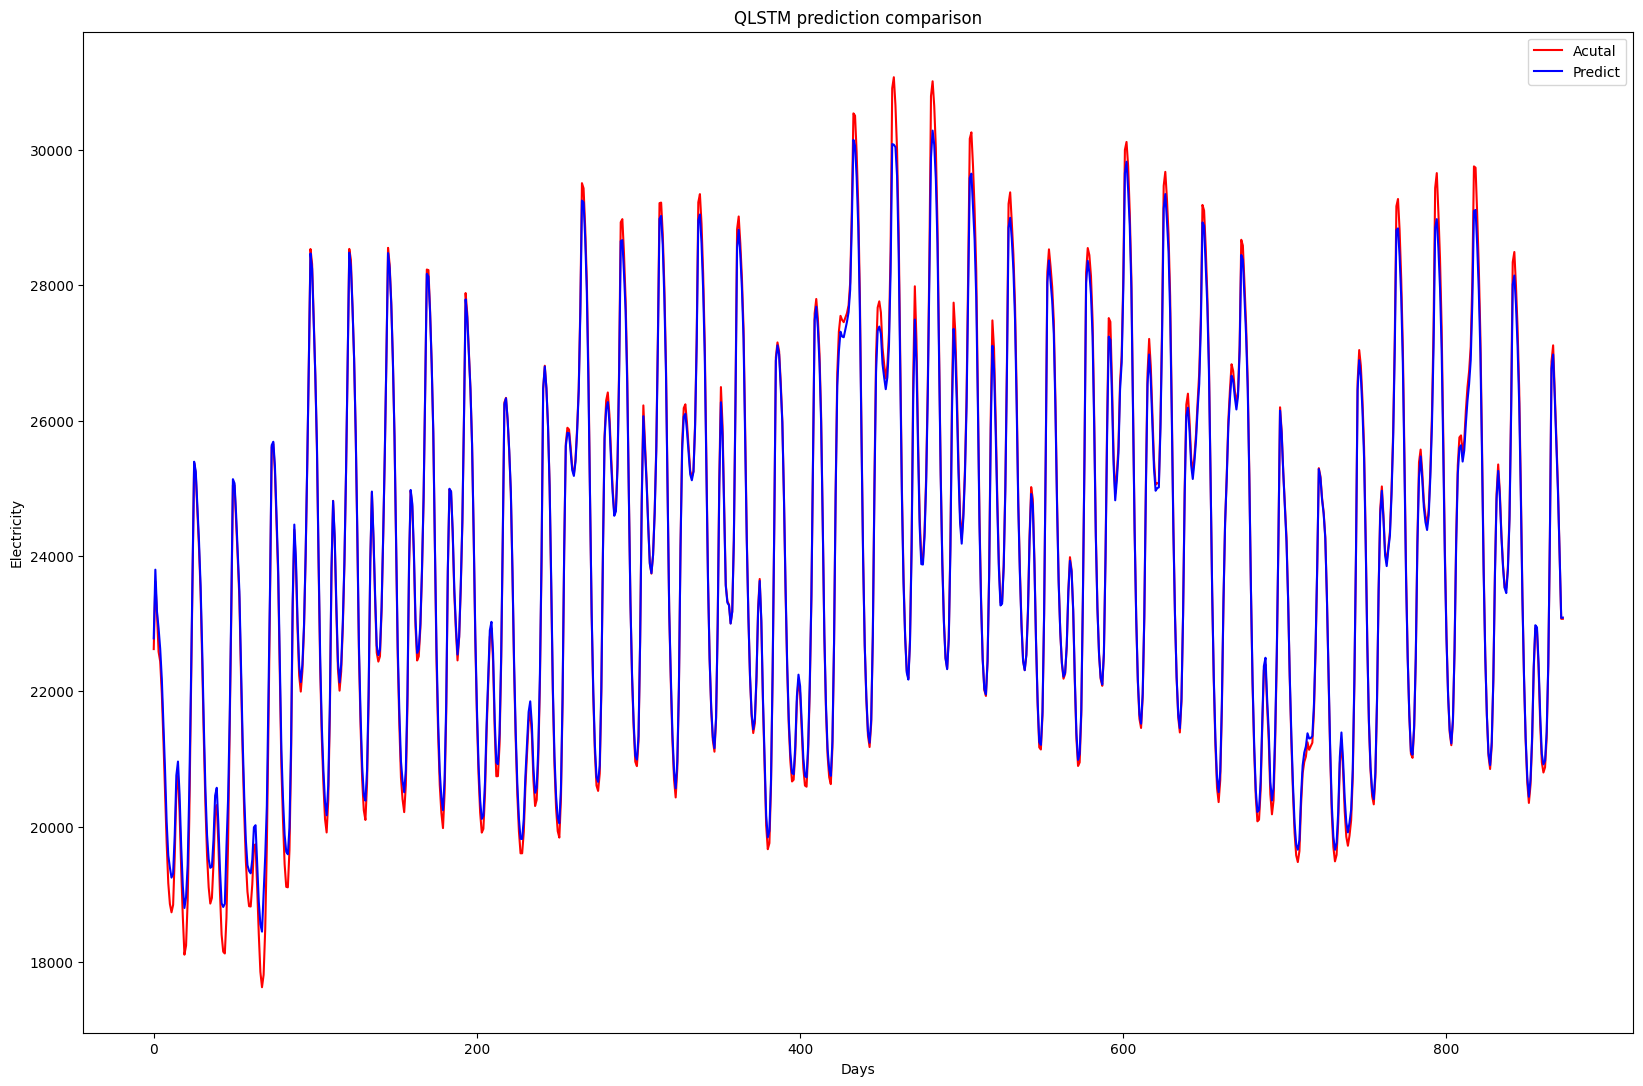

In [41]:
plt.figure(figsize=(20, 13))
plt.plot(y_test_true, color = 'red', label = 'Acutal')
plt.plot(y_test_pred, color = 'blue', label = 'Predict')
plt.title('QLSTM prediction comparison')
plt.ylabel('Electricity')
plt.xlabel('Days')
plt.legend(loc = 'upper right')

MSE = mean_squared_error(y_test_true, y_test_pred)
RMSE = math.sqrt(MSE)
print(f'Training dataset RMSE:{RMSE}')

In [42]:
torch.save(modelQ,'./SavedModels/Electricity/RE_elecDemand/model/CLSTM_attn_aqi')